In [81]:
!pip install -q segmentation-models-pytorch
!pip install segmentation-models-pytorch
!pip install pandas_profiling
!pip install albumentations
!pip install pydantic-settings

In [82]:
import os
import time
from glob import glob
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import albumentations as A
from scipy.ndimage import binary_dilation
import segmentation_models_pytorch as smp
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [84]:

import pandas as pd
files_dir = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

file_paths = glob(f'{files_dir}/*/*[0-9].tif')

In [85]:
csv_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'
df = pd.read_csv(csv_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [86]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")

df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,2.0,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,2.0,0.0
3,TCGA_CS_4944,2.0,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,2.0,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TCGA_HT_8563,2.0,5.0,3,1.0,2.0,2.0,2,1.0,2.0,1.0,3.0,2.0,1.0,30.0,3.0,2.0,0.0
106,TCGA_HT_A5RC,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,1.0,2.0,1.0,70.0,3.0,2.0,1.0
107,TCGA_HT_A616,2.0,5.0,2,1.0,2.0,2.0,1,1.0,1.0,1.0,1.0,2.0,1.0,36.0,3.0,2.0,0.0
108,TCGA_HT_A61A,2.0,5.0,2,1.0,2.0,2.0,1,3.0,1.0,1.0,1.0,6.0,1.0,20.0,3.0,2.0,0.0


In [87]:
def get_file_row(path):
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)

    patient_id = '_'.join(filename.split('_')[:3])

    return [patient_id, path, f'{path_no_ext}_mask{ext}']

In [88]:
filenames_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])
filenames_df

,Patient,image_filename,mask_filename
0,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...,...
3924,TCGA_DU_7306,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3925,TCGA_DU_7306,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3926,TCGA_DU_7306,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3927,TCGA_DU_7306,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [89]:
class MriDataset(Dataset):
    def __init__(self, df, transform=None, mean=0.5, std=0.25):


        super(MriDataset, self).__init__()
        self.df = df
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):

        return len(self.df)

    def __getitem__(self, idx, raw=False):

        row = self.df.iloc[idx]
        img = cv2.imread(row['image_filename'], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(row['mask_filename'], cv2.IMREAD_GRAYSCALE)

        if raw:

            return img, mask

        if self.transform:

            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        img = T.functional.to_tensor(img)
        mask = mask // 255
        mask = torch.Tensor(mask)

        return img, mask

In [90]:
df = pd.merge(df, filenames_df, on="Patient")

In [91]:
if df.shape[0] > 0:  # Check if DataFrame is not empty
    train_df, test_df = train_test_split(df, test_size=0.3)
    test_df, valid_df = train_test_split(test_df, test_size=0.5)
else:
    print("The dataset is empty.")

In [92]:
train_df, test_df = train_test_split(df, test_size=0.3)
test_df, valid_df = train_test_split(test_df, test_size=0.5)

In [93]:
transform = A.Compose([
    A.ChannelDropout(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(p=0.3),
])

train_dataset = MriDataset(train_df, transform)
valid_dataset = MriDataset(valid_df)
test_dataset = MriDataset(test_df)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

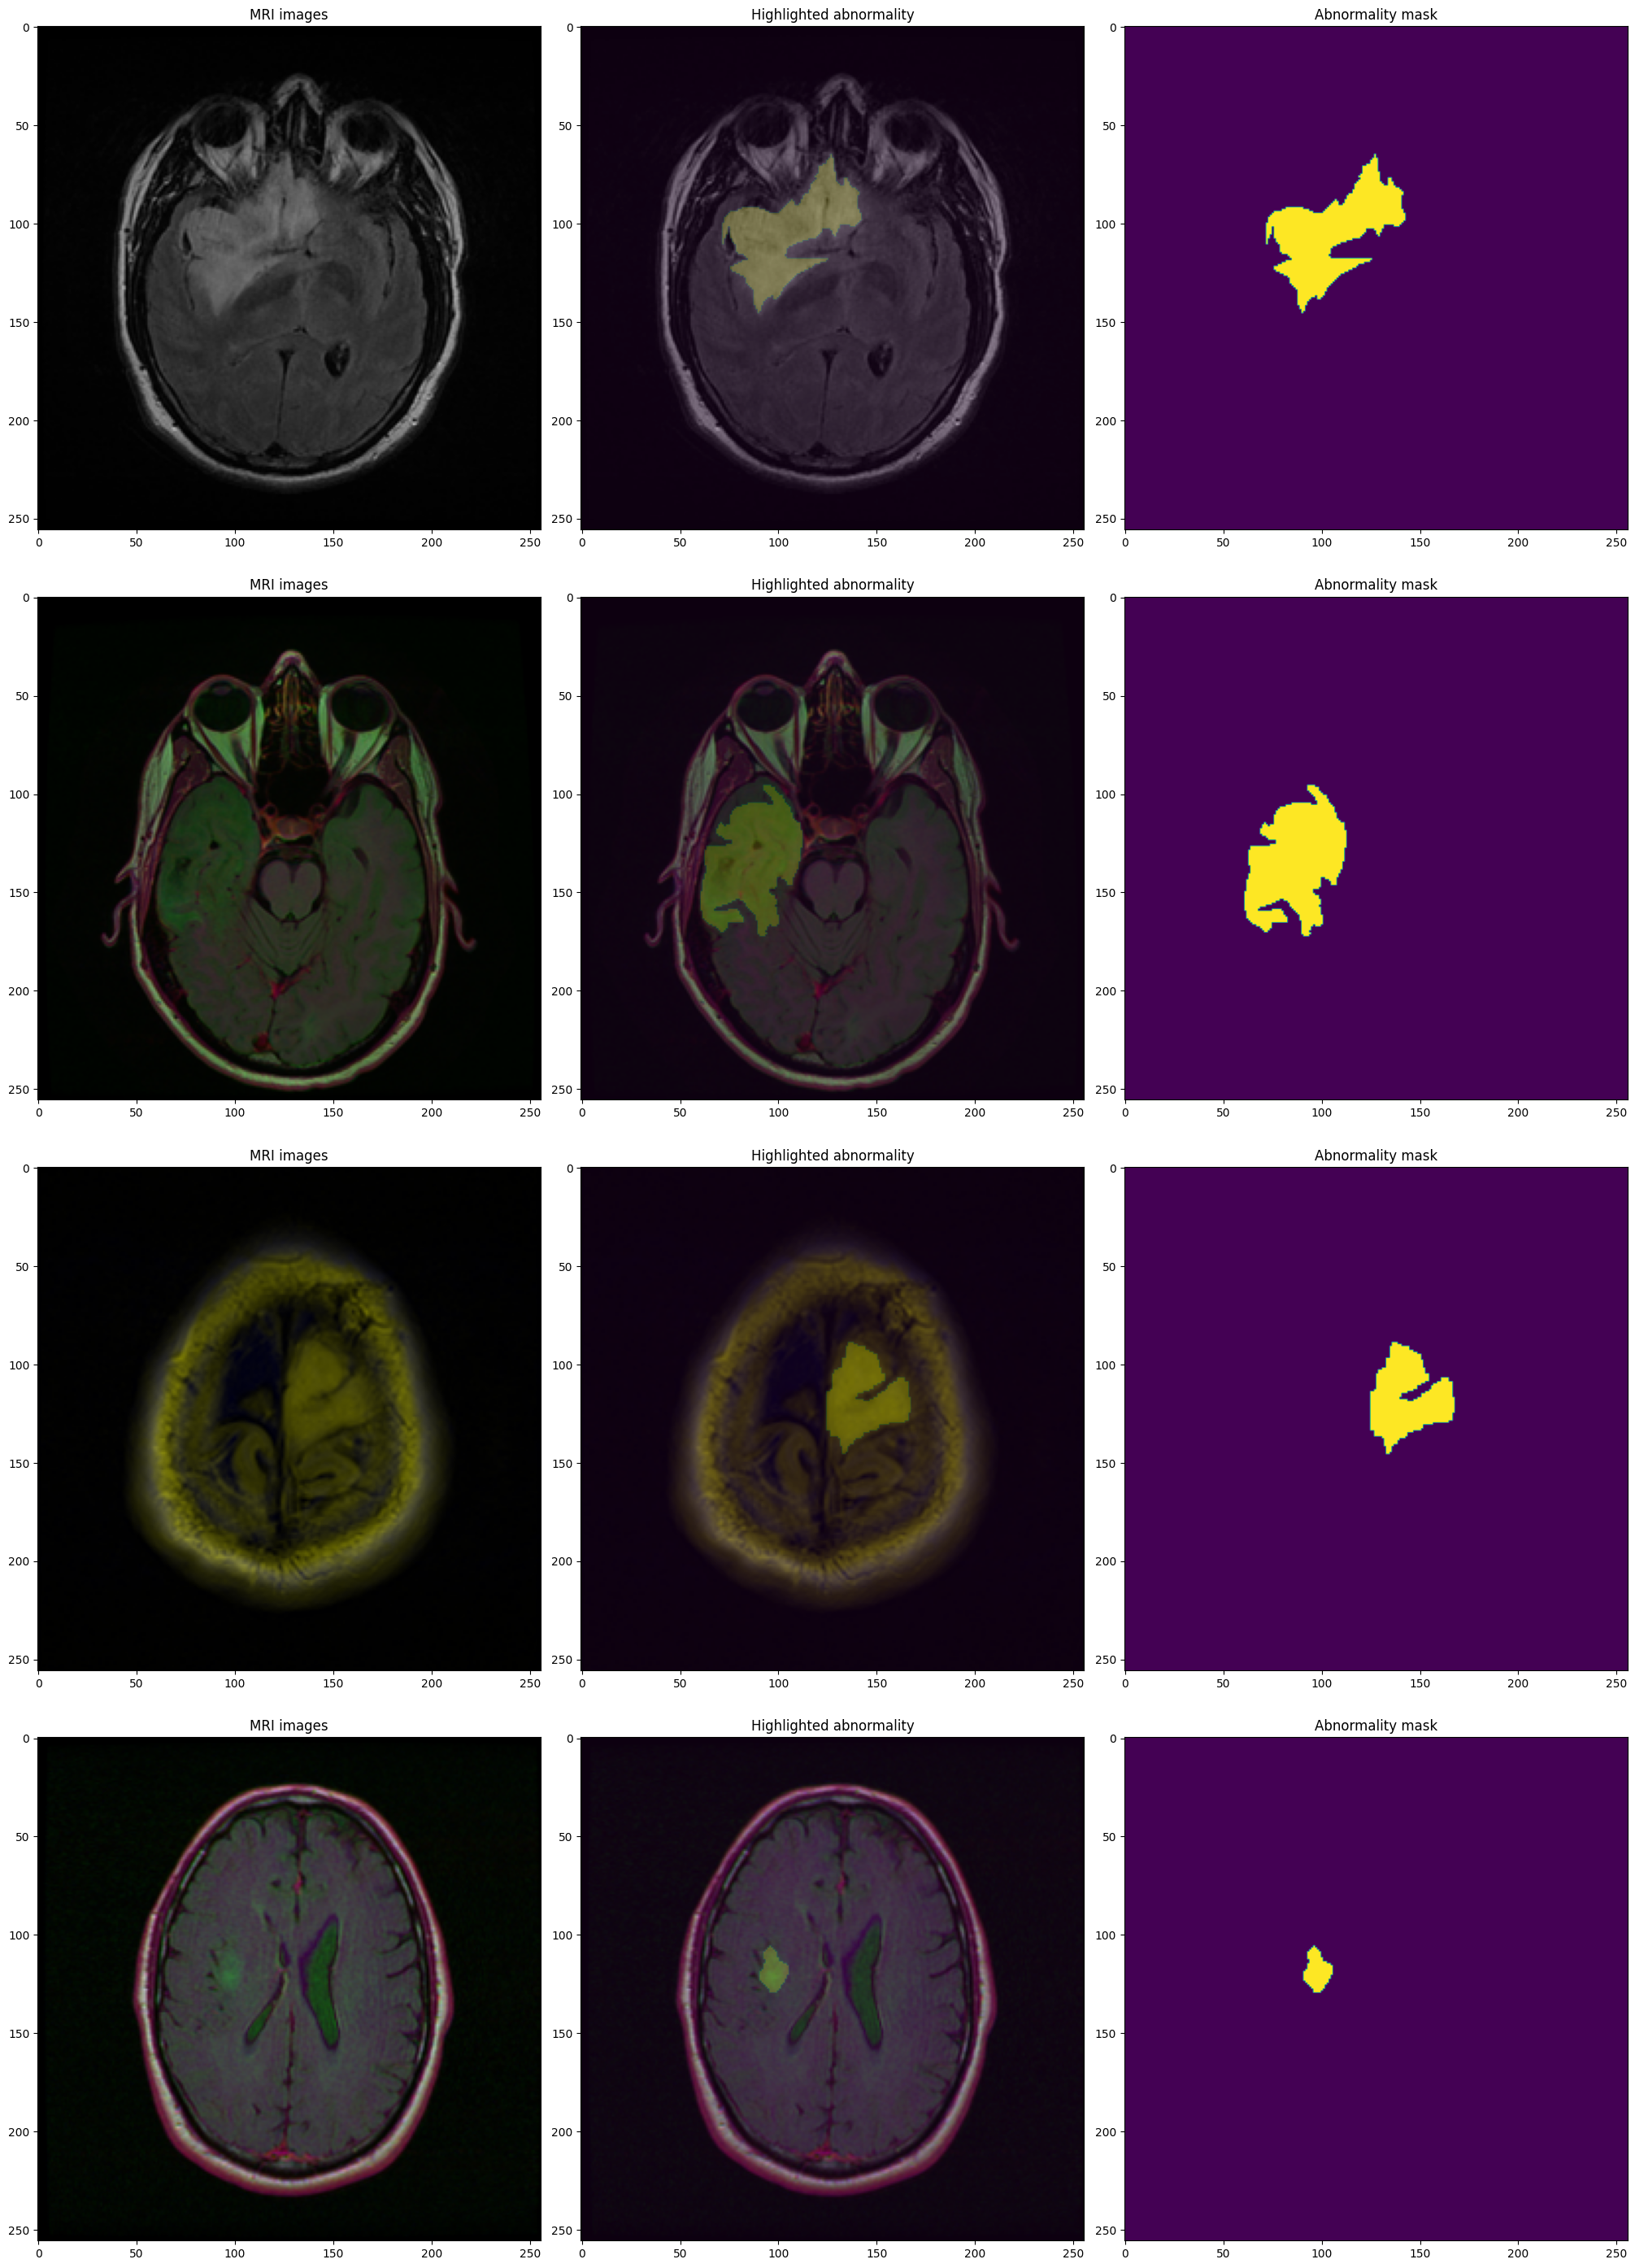

In [94]:

%matplotlib inline
n_examples = 4

fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)

i = 0
for ax in axs:
    while True:

        image, mask = train_dataset.__getitem__(i, raw=True)
        i += 1  # Incrementa el índice.

        if np.any(mask):

            ax[0].set_title("MRI images")
            ax[0].imshow(image)

            ax[1].set_title("Highlighted abnormality")
            ax[1].imshow(image)
            ax[1].imshow(mask, alpha=0.2)
            ax[2].imshow(mask)
            ax[2].set_title("Abnormality mask")
            break

In [95]:
class EarlyStopping:
    def __init__(self, patience: int = 6, min_delta: float = 0, weights_path: str = 'weights.pt', verbose: bool = False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.weights_path = weights_path
        self.verbose = verbose  # New verbose flag

    def __call__(self, val_loss: float, model: torch.nn.Module):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.weights_path)
            self.counter = 0
            if self.verbose:
                print(f"Validation loss improved to {val_loss:.4f}. Model weights saved.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in validation loss. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return True
        return False

In [96]:
def iou_pytorch(predictions: torch.Tensor, labels: torch.Tensor, e: float = 1e-7):


    predictions = torch.where(predictions > 0.5, 1, 0)

    labels = labels.byte()


    intersection = (predictions & labels).float().sum((1, 2))
    union = (predictions | labels).float().sum((1, 2))


    iou = (intersection + e) / (union + e)
    return iou

def dice_pytorch(predictions: torch.Tensor, labels: torch.Tensor, e: float = 1e-7):

    predictions = torch.where(predictions > 0.5, 1, 0)

    labels = labels.byte()


    intersection = (predictions & labels).float().sum((1, 2))

    return ((2 * intersection) + e) / (predictions.float().sum((1, 2)) + labels.float().sum((1, 2)) + e)

In [97]:
def BCE_dice(output, target, alpha=0.01):


    bce = torch.nn.functional.binary_cross_entropy(output, target)

    soft_dice = 1 - dice_pytorch(output, target).mean()

    return bce + alpha * soft_dice


model = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation='sigmoid',
)
model.to(device);

In [98]:
def training_loop(epochs, model, train_loader, valid_loader, test_loader, optimizer, loss_fn, lr_scheduler, device):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_IoU': [],
        'val_dice': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'test_accuracy': [],
    }

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(train_loader):
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            predictions = model(img)
            predictions = predictions.squeeze(1)
            loss = loss_fn(predictions, mask)
            running_loss += loss.item() * img.size(0)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Compute training accuracy
            predicted_labels = (predictions > 0.5).float()
            correct_train += (predicted_labels == mask).sum().item()
            total_train += mask.numel()

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0
        running_IoU = 0
        running_dice = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for i, data in enumerate(valid_loader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                predictions = predictions.squeeze(1)
                val_loss = loss_fn(predictions, mask)
                running_val_loss += val_loss.item() * img.size(0)

                # Compute validation metrics
                running_IoU += iou_pytorch(predictions, mask).sum().item()
                running_dice += dice_pytorch(predictions, mask).sum().item()
                predicted_labels = (predictions > 0.5).float()
                correct_val += (predicted_labels == mask).sum().item()
                total_val += mask.numel()

        # Calculate average validation metrics
        val_loss = running_val_loss / len(valid_loader.dataset)
        history['val_loss'].append(val_loss)
        val_IoU = running_IoU / len(valid_loader.dataset)
        history['val_IoU'].append(val_IoU)
        val_dice = running_dice / len(valid_loader.dataset)
        history['val_dice'].append(val_dice)
        val_accuracy = correct_val / total_val
        history['val_accuracy'].append(val_accuracy)

        # Print epoch results
        print(
            f"Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val IoU: {val_IoU:.4f}, Val Dice: {val_dice:.4f}"
        )

        # Learning rate adjustment
        lr_scheduler.step(val_loss)

    # Testing phase
    print("Starting Testing Phase...")
    running_test_accuracy = 0
    total_test = 0

    model.eval()
    with torch.no_grad():
        for data in test_loader:
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            predictions = model(img)
            predictions = predictions.squeeze(1)

            # Compute test accuracy
            predicted_labels = (predictions > 0.5).float()
            running_test_accuracy += (predicted_labels == mask).sum().item()
            total_test += mask.numel()

    test_accuracy = running_test_accuracy / total_test
    history['test_accuracy'].append(test_accuracy)

    print(f"Test Accuracy: {test_accuracy:.4f}")

    return history


In [99]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check for CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model, optimizer, loss function, and scheduler
# Make sure `BCE_dice` and `model` are defined before this code block
loss_fn = BCE_dice  # Replace BCE_dice with your loss function
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 10
lr_scheduler = ReduceLROnPlateau(optimizer=optimizer, patience=2, factor=0.2)

# Move model to the device
model = model.to(device)

# Make sure `train_loader`, `valid_loader`, and `test_loader` are defined
# Run the training loop
history = training_loop(epochs, model, train_loader, valid_loader, test_loader, optimizer, loss_fn, lr_scheduler, device)


Epoch [1/10], Train Loss: 0.0876, Train Acc: 0.9890, Val Loss: 0.0340, Val Acc: 0.9933, Val IoU: 0.7542, Val Dice: 0.7869
Epoch [2/10], Train Loss: 0.0209, Train Acc: 0.9950, Val Loss: 0.0220, Val Acc: 0.9927, Val IoU: 0.7735, Val Dice: 0.8168
Epoch [3/10], Train Loss: 0.0154, Train Acc: 0.9957, Val Loss: 0.0135, Val Acc: 0.9961, Val IoU: 0.8336, Val Dice: 0.8683
Epoch [4/10], Train Loss: 0.0131, Train Acc: 0.9961, Val Loss: 0.0119, Val Acc: 0.9963, Val IoU: 0.8366, Val Dice: 0.8700
Epoch [5/10], Train Loss: 0.0121, Train Acc: 0.9965, Val Loss: 0.0105, Val Acc: 0.9968, Val IoU: 0.8573, Val Dice: 0.8895
Epoch [6/10], Train Loss: 0.0097, Train Acc: 0.9970, Val Loss: 0.0089, Val Acc: 0.9972, Val IoU: 0.8628, Val Dice: 0.8946
Epoch [7/10], Train Loss: 0.0088, Train Acc: 0.9973, Val Loss: 0.0093, Val Acc: 0.9972, Val IoU: 0.8644, Val Dice: 0.8925
Epoch [8/10], Train Loss: 0.0083, Train Acc: 0.9974, Val Loss: 0.0079, Val Acc: 0.9975, Val IoU: 0.8656, Val Dice: 0.8955
Epoch [9/10], Train Loss

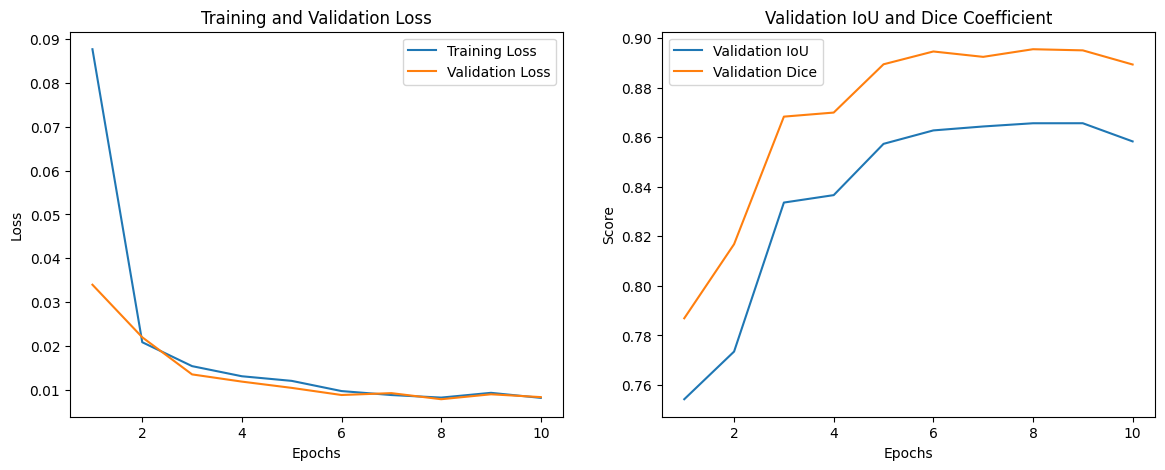

In [100]:
import matplotlib.pyplot as plt

# Assuming history is a dictionary containing 'train_loss', 'val_loss', 'val_IoU', 'val_dice'

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Training and Validation Loss
    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # IoU and Dice plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_IoU'], label='Validation IoU')
    plt.plot(epochs, history['val_dice'], label='Validation Dice')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Validation IoU and Dice Coefficient')
    plt.legend()

    plt.show()

# Call this function to plot your training history
plot_training_history(history)

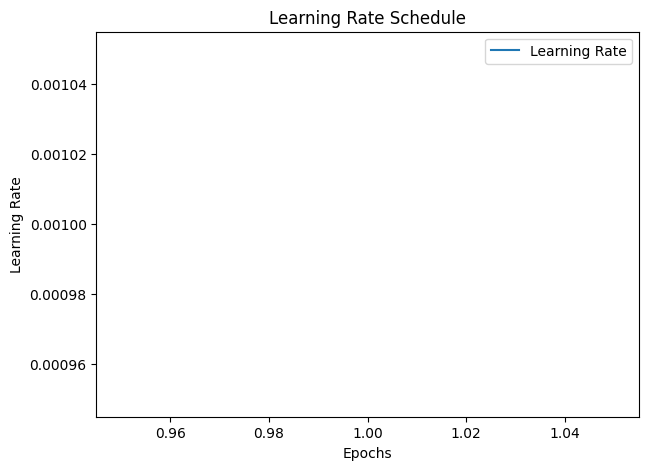

In [104]:
lrs = [param_group['lr'] for param_group in optimizer.param_groups]

# Plot learning rate over epochs
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(lrs) + 1), lrs, label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

In [105]:
torch.save(model,"model.pth")

In [107]:
def visualize_predictions(model, data_loader, device):
    model.eval()
    data_iter = iter(data_loader)
    images, masks = next(data_iter)

    with torch.no_grad():
        images, masks = images.to(device), masks.to(device)
        predictions = model(images).squeeze(1)

    # Plot the first few images, masks, and predictions
    plt.figure(figsize=(15, 5))
    for i in range(3):
        # Convert images to NumPy format and reorder dimensions
        input_image = images[i].cpu().permute(1, 2, 0).numpy()
        ground_truth = masks[i].cpu().squeeze().numpy()
        prediction = predictions[i].cpu().squeeze().numpy()

        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(input_image, cmap='gray' if input_image.shape[-1] == 1 else None)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(ground_truth, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(prediction, cmap='gray')
        plt.title("Model Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

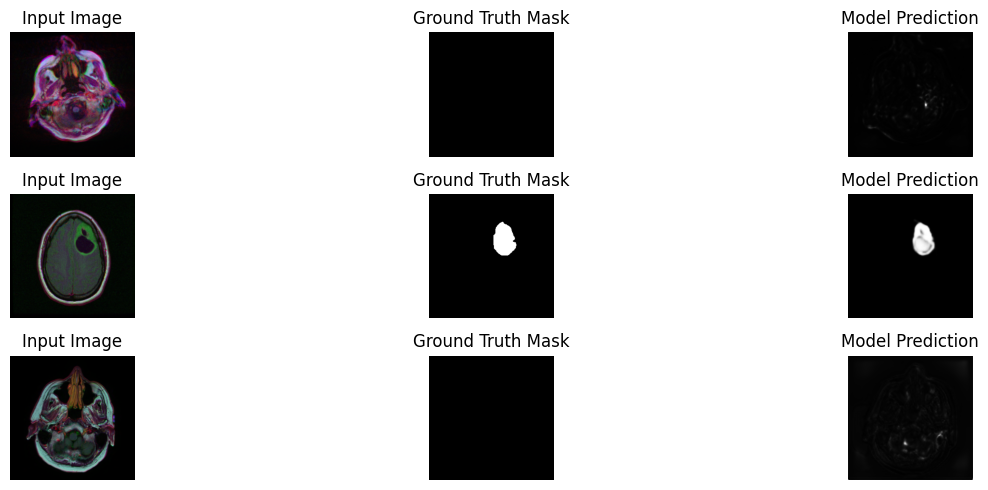

In [111]:
visualize_predictions(model,valid_loader,device)